In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

In [3]:
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [5]:
!pip install -q findspark
import findspark
findspark.init()

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('logregconsult').getOrCreate()

In [ ]:
data = spark.read.csv('dataset.csv',inferSchema=True,header=True)

In [8]:
from pyspark.ml.feature import VectorAssembler, IndexToString,StringIndexer, VectorIndexer

def transform_set(data):
  assembler = VectorAssembler(inputCols=[str(i) for i in range(1,205)],outputCol='features')
  output = assembler.transform(data)
  return output.select('features', 'family')

In [9]:
trainset,testset = data.randomSplit([0.6,0.4])

data = transform_set(data)
trainset = transform_set(trainset)
testset = transform_set(testset)

trainset.show(5)
testset.show(5)

+--------------------+------+
|            features|family|
+--------------------+------+
|[0.25,0.0625,0.25...|Benign|
|[0.25,0.0625,0.25...|Benign|
|[0.0625,0.0625,0....|   SMS|
|[0.25,0.0625,0.25...|Benign|
|[0.125,0.0625,0.2...|Benign|
+--------------------+------+
only showing top 5 rows

+--------------------+-------+
|            features| family|
+--------------------+-------+
|[0.0625,0.0625,0....|Banking|
|[0.125,0.0625,0.0...| Adware|
|[0.0625,0.0625,0....|Banking|
|[0.0625,0.0625,0....|    SMS|
|[0.125,0.0625,0.0...| Adware|
+--------------------+-------+
only showing top 5 rows



In [10]:
label_indexer = StringIndexer(inputCol='family', outputCol='indexedLabel', handleInvalid="keep").fit(trainset)

features_indexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5, handleInvalid="keep").fit(trainset)

In [11]:
label_indexer.transform(trainset).show(5)
features_indexer.transform(trainset).show(5)

+--------------------+------+------------+
|            features|family|indexedLabel|
+--------------------+------+------------+
|[0.25,0.0625,0.25...|Benign|         2.0|
|[0.25,0.0625,0.25...|Benign|         2.0|
|[0.0625,0.0625,0....|   SMS|         0.0|
|[0.25,0.0625,0.25...|Benign|         2.0|
|[0.125,0.0625,0.2...|Benign|         2.0|
+--------------------+------+------------+
only showing top 5 rows

+--------------------+------+--------------------+
|            features|family|     indexedFeatures|
+--------------------+------+--------------------+
|[0.25,0.0625,0.25...|Benign|[2.0,0.0,2.0,2.0,...|
|[0.25,0.0625,0.25...|Benign|[2.0,0.0,2.0,2.0,...|
|[0.0625,0.0625,0....|   SMS|[0.0,0.0,0.0,0.0,...|
|[0.25,0.0625,0.25...|Benign|[2.0,0.0,2.0,2.0,...|
|[0.125,0.0625,0.2...|Benign|[1.0,0.0,2.0,2.0,...|
+--------------------+------+--------------------+
only showing top 5 rows



In [12]:
from pyspark.ml.classification import LogisticRegression


logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=label_indexer.labels)

print(label_indexer.labels)

['SMS', 'Riskware', 'Benign', 'Banking', 'Adware']


In [13]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[label_indexer, features_indexer, logr,labelConverter])

model = pipeline.fit(trainset)

In [14]:
predictions = model.transform(testset)


predictions.select("features","family","predictedLabel").show(5)

+--------------------+-------+--------------+
|            features| family|predictedLabel|
+--------------------+-------+--------------+
|[0.0625,0.0625,0....|Banking|       Banking|
|[0.125,0.0625,0.0...| Adware|        Adware|
|[0.0625,0.0625,0....|Banking|       Banking|
|[0.0625,0.0625,0....|    SMS|           SMS|
|[0.125,0.0625,0.0...| Adware|        Adware|
+--------------------+-------+--------------+
only showing top 5 rows



In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0564226


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
class_temp = predictions.select("family").groupBy("family")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["family"].values.tolist()
class_names = list(map(str, class_temp))

print(class_names)

['SMS', 'Riskware', 'Benign', 'Banking', 'Adware']


In [18]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("family")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[1894,   11,    3,    4,    4],
       [  15, 1527,   24,   35,   28],
       [   7,   39, 1501,   23,    5],
       [  18,   47,   32,  819,   17],
       [   7,   27,   10,   20,  547]])

Confusion matrix, without normalization
[[1894   11    3    4    4]
 [  15 1527   24   35   28]
 [   7   39 1501   23    5]
 [  18   47   32  819   17]
 [   7   27   10   20  547]]


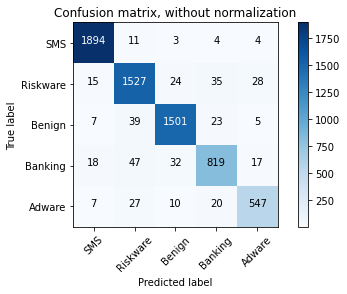

In [19]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [23]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import HashingTF

paramGrid = ParamGridBuilder() \
    .addGrid(HashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(logr.regParam, [0.1, 0.01]) \
    .build()
cv = CrossValidator(estimator=pipeline, evaluator=MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"), estimatorParamMaps=paramGrid)

cvModel = cv.fit(data)

In [25]:
model = cvModel.bestModel


In [26]:
import shutil

model_path = "./apkAnalysis"
model.write().overwrite().save(model_path)
path_drv = shutil.make_archive("apkClassification", format='zip', base_dir=model_path)